# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value" ICML 2023 , using pyDVL.
https://proceedings.mlr.press/v202/kwon23e.html

The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [20]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std, plot_best_worst, plot_best_worst_class_imbalance, compute_best_worst_scores, plot_methods_linreg
from pydvl.value.result import ValuationResult

In [22]:

from sklearn.datasets import load_iris, fetch_kddcup99, fetch_openml
import pandas as pd

In [23]:
import pandas as pd

# Specify the URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Specify the column names
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

# Specify the data types for each column
data_types = {
    "age": int,
    "workclass": "category",
    "fnlwgt": int,
    "education": "category",
    "education-num": int,
    "marital-status": "category",
    "occupation": "category",
    "relationship": "category",
    "race": "category",
    "sex": "category",
    "capital-gain": int,
    "capital-loss": int,
    "hours-per-week": int,
    "native-country": "category",
    "income": "category",
}

# Load the dataset into a pandas DataFrame
data_adult = pd.read_csv(
    url,
    names=column_names,
    sep=",\s*",
    engine="python",
    na_values="?",
    dtype=data_types,
    nrows=50000,
)

# Drop categorical columns
data_adult = data_adult.drop(
    columns=[
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ]
)

data_adult = data_adult.sample(frac=1)
# Display the first few rows of the dataframe
print(data_adult.head())
data = Dataset.from_arrays(
    X=data_adult.drop(columns=["income"]).values,
    y=data_adult.loc[:, "income"].cat.codes.values,
)

       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
19903   18  126071              9             0             0              40   
11507   43  117627             10             0             0              40   
5883    58  231818              6             0             0              40   
3389    51  293196             16         15024             0              60   
5006    19  283033              7             0             0              40   

      income  
19903  <=50K  
11507  <=50K  
5883   <=50K  
3389    >50K  
5006   <=50K  


In [24]:

#model = KNeighborsClassifier(n_neighbors=5)
model = DecisionTreeClassifier(max_depth=5,)
#model = LogisticRegression()
utility = Utility(model, data, Scorer("balanced_accuracy", default=0.0))

# Varying Objective scorer

> :warning: This is useless as oob does not rely on the scorer. It relies on point wise error metrics.  :warning:

In [25]:
def oob_func(utility, scorer_name):
    
    return(compute_data_oob(Utility(utility.model, utility.data, Scorer(scorer_name)), n_est=30, max_samples=0.6, progress=False))
scorer_name_list = ["accuracy"]#, "f1", "roc_auc", "balanced_accuracy","neg_log_loss"]
func = oob_func
kwargs_list = [{"scorer_name":scorer_name} for scorer_name in scorer_name_list]

# Base estimator

In [26]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF

In [27]:

scorer = Scorer("balanced_accuracy", default=0.0)

model = LogisticRegression()
dict_utilities = {}
utility = Utility(KNeighborsClassifier(n_neighbors=5), data, scorer)
dict_utilities["KNN"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=2,), data, scorer)
dict_utilities["DecisionTreeShallow"] = utility
utility = Utility(DecisionTreeClassifier(max_depth=20,), data, scorer)
dict_utilities["DecisionTreeDeep"] = utility
utility = Utility(LogisticRegression(), data, scorer)
dict_utilities["LogisticRegression"] = utility
#utility = Utility(GaussianProcessClassifier(1.0 * RBF(1.0)), data, scorer)
#dict_utilities["GaussianProcess"] = utility
#utility = Utility(GaussianNB(), data, scorer)
#dict_utilities["GaussianNB"] = utility
#utility = Utility(MLPClassifier(), data, scorer)
#dict_utilities["MLPClassifier"] = utility
utility = Utility(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), data, scorer)
dict_utilities["RandomForest"] = utility
utility = Utility(AdaBoostClassifier(), data, scorer)
dict_utilities["AdaBoost"] = utility
utility = Utility(LGBMClassifier(verbose= -1), data, scorer)
dict_utilities["LGBM"] = utility

dict_utilities.keys()

dict_keys(['KNN', 'DecisionTreeShallow', 'DecisionTreeDeep', 'LogisticRegression', 'RandomForest', 'AdaBoost', 'LGBM'])

In [28]:

area_under_curve_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
area_under_curve_worse = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))

In [29]:
area_under_curve_best.LGBM

KNN                    NaN
DecisionTreeShallow    NaN
DecisionTreeDeep       NaN
LogisticRegression     NaN
RandomForest           NaN
AdaBoost               NaN
LGBM                   NaN
Name: LGBM, dtype: object

In [30]:
area_under_curve_worse.LGBM

KNN                    NaN
DecisionTreeShallow    NaN
DecisionTreeDeep       NaN
LogisticRegression     NaN
RandomForest           NaN
AdaBoost               NaN
LGBM                   NaN
Name: LGBM, dtype: object

In [31]:
def compute_random_baseline_best_worst_mean(n_iter, utility_eval, removal_percentages):
    random_vals = [ValuationResult.from_random(size=len(utility.data)) for _ in range(n_iter)]
    best_random_score = [compute_removal_score(u=utility,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=True,) for vals in random_vals]
    df_random_best = pd.DataFrame(best_random_score)
    df_random_best = df_random_best.mean()

    worst_random_score = [compute_removal_score(u=utility_eval,
                                            values=vals,
                                            percentages=removal_percentages,
                                            remove_best=False,) for vals in random_vals]
    df_random_worst = pd.DataFrame(best_random_score)
    df_random_worst = df_random_worst.mean()
    return(df_random_best, df_random_worst)

In [34]:

for k in kwargs_list:
    print(k)

{'scorer_name': 'accuracy'}


In [32]:
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.05)

area_under_curve_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
area_under_curve_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
percent_above_random_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
diff_random_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
diff_random_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
single_best_gain_best = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))
single_best_gain_worst = pd.DataFrame(index=list(dict_utilities.keys()), columns=list(dict_utilities.keys()))

for k in kwargs_list:
    model_name = k["model_name"]
    utility_eval = dict_utilities[model_name]
    df_random_best, df_random_worst = compute_random_baseline_best_worst_mean(n_iter, utility_eval, removal_percentages)
    best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list,f_name="", return_values=True)
    best_scores_df.loc[:,"method_name"] = best_scores_df.loc[:,"method_name"].apply(lambda x: "_".join(x.split("_")[1:]))
    worst_scores_df.loc[:,"method_name"] = worst_scores_df.loc[:,"method_name"].apply(lambda x: "_".join(x.split("_")[1:]))
    df_mean_best = best_scores_df.groupby("method_name").mean()
    df_mean_worst = worst_scores_df.groupby("method_name").mean()

    area_under_curve_best.loc[:,model_name] = df_mean_best.sum(axis=1)/len(removal_percentages)
    area_under_curve_worst.loc[:,model_name] = df_mean_worst.sum(axis=1)/len(removal_percentages)

    best_compare_random = df_mean_best.apply(lambda row: np.array(row.values < df_random_best, dtype=int), axis=1)
    worst_compare_random = df_mean_worst.apply(lambda row: np.array(row.values > df_random_worst, dtype=int), axis=1)
    percent_above_random_best.loc[:,model_name] = best_compare_random.apply(lambda x: np.mean(x))
    percent_above_random_worst.loc[:,model_name] = worst_compare_random.apply(lambda x: np.mean(x))

    diff_random_best.loc[:,model_name] = df_mean_best.apply(lambda row: sum(np.array(row.values - df_random_best, dtype=float)), axis=1)
    diff_random_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: sum(np.array(row.values - df_random_worst, dtype=float)), axis=1)

    single_best_gain_best.loc[:,model_name] = df_mean_best.apply(lambda row: max(np.array(row.values - df_random_best, dtype=float)), axis=1)
    single_best_gain_worst.loc[:,model_name] = df_mean_worst.apply(lambda row: min(np.array(row.values - df_random_worst, dtype=float)), axis=1)

    

KeyError: 'model_name'

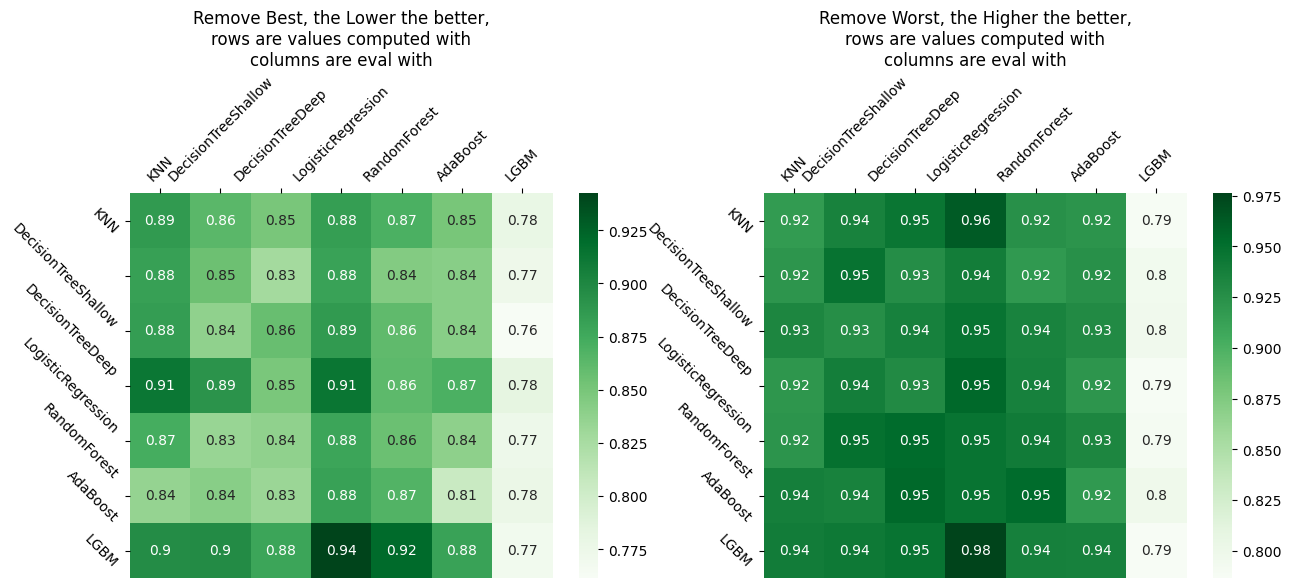

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(area_under_curve_best.loc[col_order,col_order], annot=True,ax=ax[0], cmap="Greens")
sns.heatmap(area_under_curve_worst.loc[col_order,col_order], annot=True,ax=ax[1], cmap="Greens")

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Best, the Lower the better,\nrows are values computed with\ncolumns are eval with")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Worst, the Higher the better,\nrows are values computed with\ncolumns are eval with")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
plt.show()

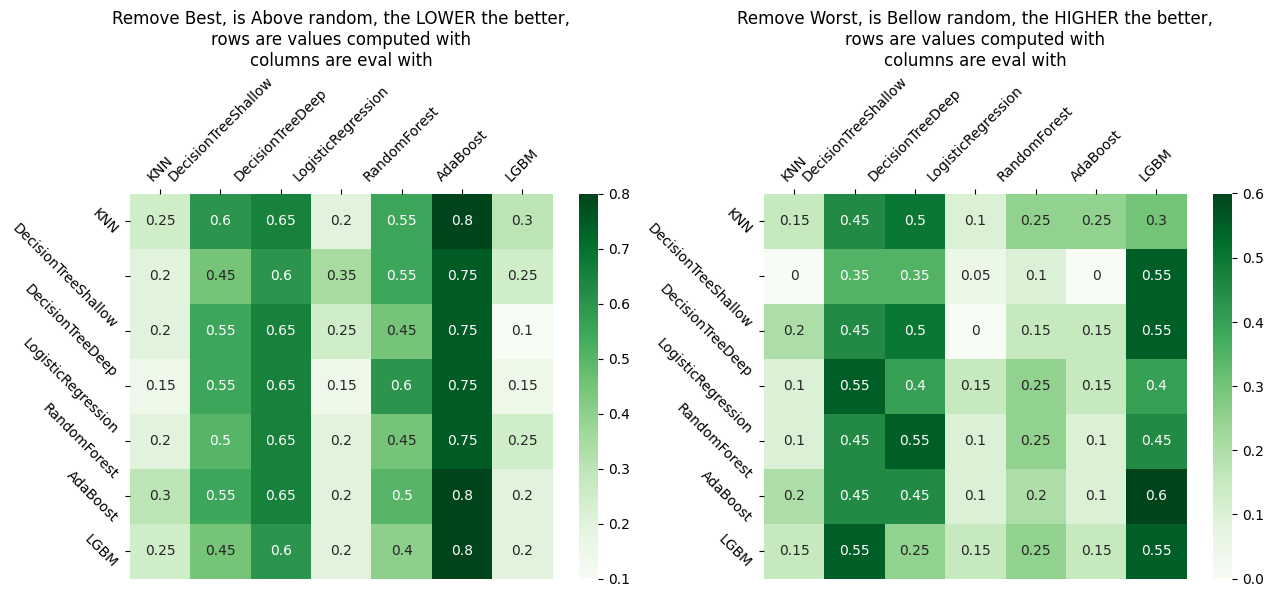

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(percent_above_random_best.loc[col_order,col_order], annot=True,ax=ax[0], cmap = "Greens")
sns.heatmap(percent_above_random_worst.loc[col_order,col_order], annot=True,ax=ax[1], cmap = "Greens")

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Best, is Above random, the LOWER the better,\nrows are values computed with\ncolumns are eval with")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Worst, is Bellow random, the HIGHER the better,\nrows are values computed with\ncolumns are eval with")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
plt.show()

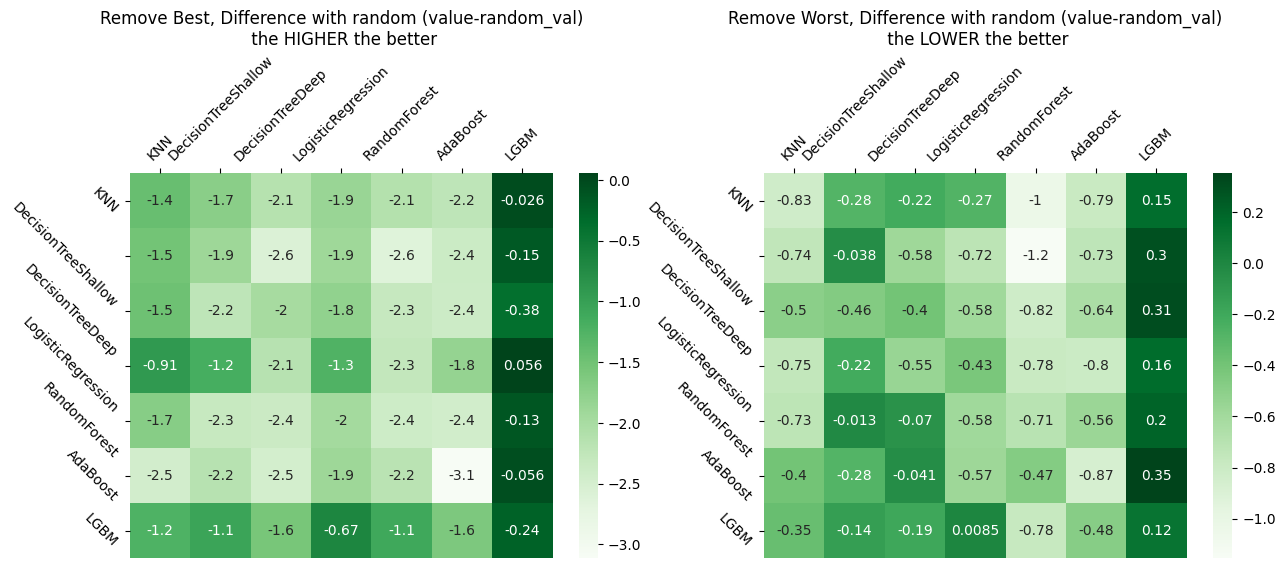

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(diff_random_best.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')
sns.heatmap(diff_random_worst.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens')

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Best, Difference with random (value-random_val)\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Worst, Difference with random (value-random_val)\n the LOWER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
plt.show()

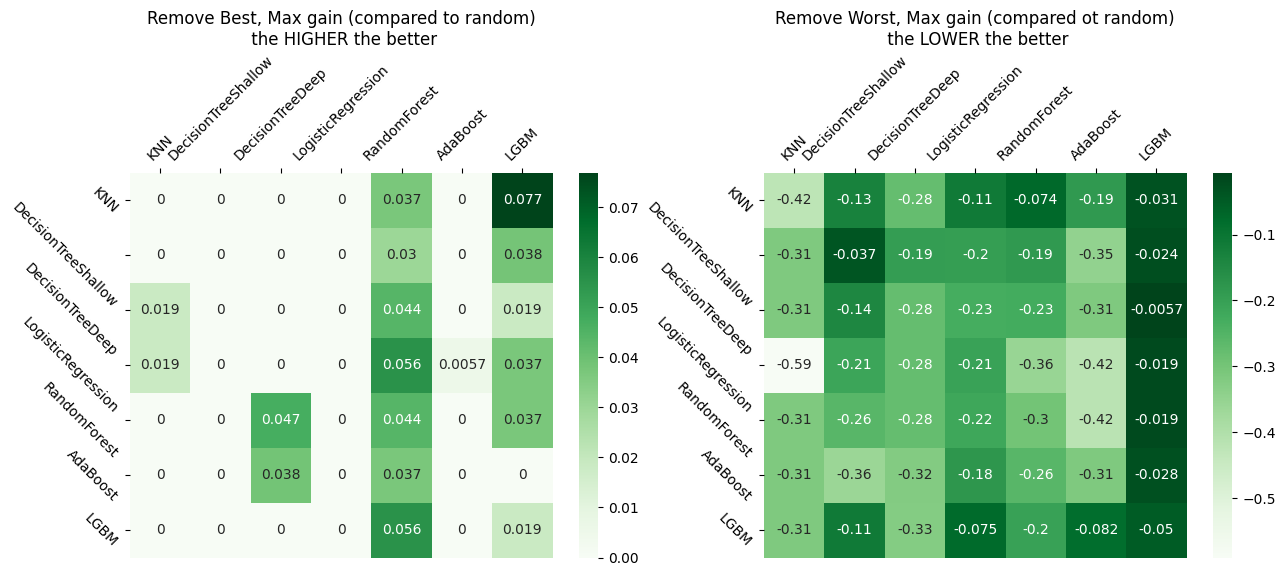

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize =[15,5])
col_order = list(area_under_curve_best.columns)
sns.heatmap(single_best_gain_best.loc[col_order,col_order], annot=True,ax=ax[0], cmap = 'Greens')
sns.heatmap(single_best_gain_worst.loc[col_order,col_order], annot=True,ax=ax[1], cmap = 'Greens')

ax[0].xaxis.tick_top()
ax[0].set_title("Remove Best, Max gain (compared to random)\n the HIGHER the better")
ax[0].set_xticklabels(col_order, rotation = 45)
ax[0].set_yticklabels(col_order, rotation = -45)
ax[1].xaxis.tick_top()
ax[1].set_title("Remove Worst, Max gain (compared ot random)\n the LOWER the better")
ax[1].set_xticklabels(col_order, rotation = 45)
ax[1].set_yticklabels(col_order, rotation = -45)
plt.show()

# Validate previous results

In [ ]:
def oob_func(utility, _):
    return(compute_data_oob(utility, n_est=30, max_samples=0.8, progress=False))
kwargs_list = [{"_":"_"}]

In [ ]:
model = LogisticRegression()
utility = dict_utilities["DecisionTreeDeep"]
utility_eval = dict_utilities["RandomForest"]
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)

compute_data_oob(utility, n_est=30, max_samples=0.8, progress=False)

best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, removal_percentages, n_iter, oob_func, kwargs_list, return_values=True)

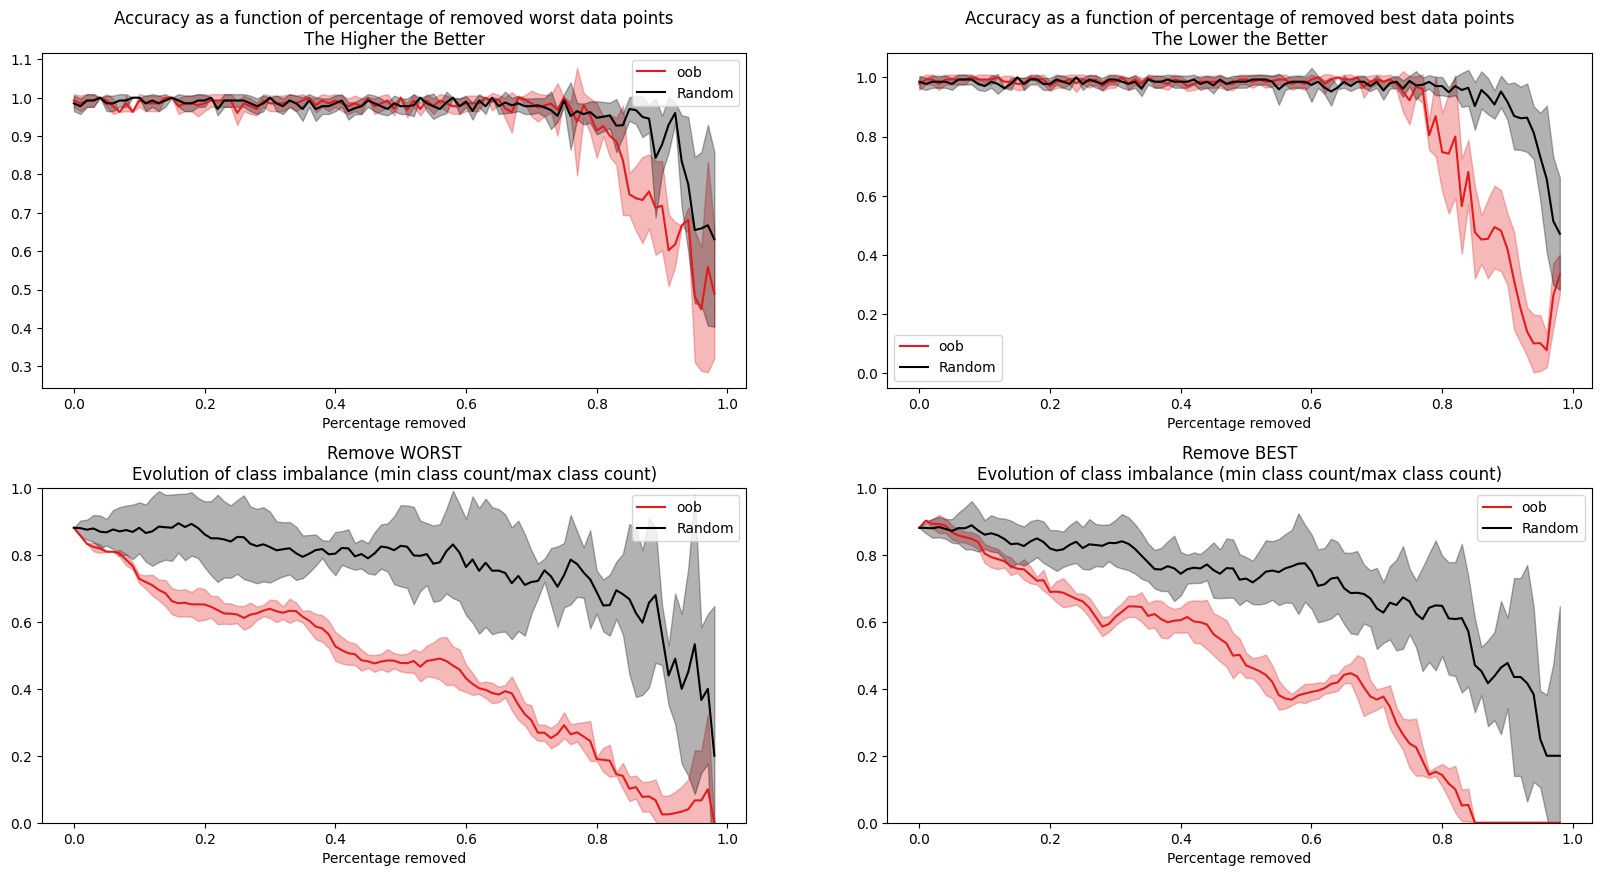

In [ ]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1", random_run=True)